# Taller teórico-práctico de Detección de Objetos para Robots DOR2019

Este notebook toma grandes partes del código de dos fuentes: 

* El Demo de object detection de TensorFlow, que viene por defecto en la distribución de Tensorflow/Models, y que es el punto de partida para aplicaciones: 
https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb


* El código del equipo Cheesecake (Claudia Winklmayr, Sevim Calikstan y Samuel Bustamante) en el Deep Learning and Robotics Challenge 2018
https://github.com/ClaudiaWinklmayr/Cheesecake/tree/finaldaydemo

El código se comparte con fines educativos.

-------


### Instrucciones de instalación: 
ToDo

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import cv2 

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
    raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')

from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

# This is needed to display the images.
%matplotlib inline

## Descarga del modelo:

En esta sección se descargará el modelo y la gráfica de TF.
A continuación dejo los comentarios originales del autor del Demo. Sugiero leer sobre el [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md).

#### El modelo:
Son bienvenidos de explorar diferents modelos. Por lo pronto recomiendo usar el modelo [SSD](https://medium.com/@jonathan_hui/ssd-object-detection-single-shot-multibox-detector-for-real-time-processing-9bd8deac0e06) para una detección rápida, y el modelo fasterrcnn para una detección robusta:


----


*Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.*

*By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.*

In [2]:
# What model to download.
#MODEL_NAME = 'ssdlite_mobilenet_v2_coco_2018_05_09' #https://arxiv.org/pdf/1512.02325.pdf
MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_coco_2018_01_28'


MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

In [3]:
if(not(os.path.isfile(PATH_TO_FROZEN_GRAPH))): #Si no existe...
    opener = urllib.request.URLopener()
    opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
    tar_file = tarfile.open(MODEL_FILE)
    for file in tar_file.getmembers():
      file_name = os.path.basename(file.name)
      if 'frozen_inference_graph.pb' in file_name:
        tar_file.extract(file, os.getcwd())

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')


In [4]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

La categoría predilecta debe ser **87:** *scissors*.

In [5]:
category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

## Toolbox 
Funciones útiles para diferentes tareas. Adaptado de las fuentes citadas al inicio.

In [17]:
class DORtoolbox:
    
    @staticmethod
    def load_image_into_numpy_array(image):
      (im_width, im_height) = image.size
      return np.array(image.getdata()).reshape(
          (im_height, im_width, 3)).astype(np.uint8)
    
    #PENDING: FIX INDENTATION
    @staticmethod
    def run_inference_for_single_image(image, graph):
      with graph.as_default():
        with tf.Session() as sess:
          # Get handles to input and output tensors
          ops = tf.get_default_graph().get_operations()
          all_tensor_names = {output.name for op in ops for output in op.outputs}
          tensor_dict = {}
          for key in [
              'num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks'
          ]:
            tensor_name = key + ':0'
            if tensor_name in all_tensor_names:
              tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                  tensor_name)
          if 'detection_masks' in tensor_dict:
            # The following processing is only for single image
            detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
            detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
            # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
            real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
            detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
            detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
            detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                detection_masks, detection_boxes, image.shape[0], image.shape[1])
            detection_masks_reframed = tf.cast(
                tf.greater(detection_masks_reframed, 0.5), tf.uint8)
            # Follow the convention by adding back the batch dimension
            tensor_dict['detection_masks'] = tf.expand_dims(
                detection_masks_reframed, 0)
          image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

          # Run inference
          output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})

          # all outputs are float32 numpy arrays, so convert types as appropriate
          output_dict['num_detections'] = int(output_dict['num_detections'][0])
          output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.uint8)
          output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
          output_dict['detection_scores'] = output_dict['detection_scores'][0]
          if 'detection_masks' in output_dict:
            output_dict['detection_masks'] = output_dict['detection_masks'][0]
      return output_dict
    
    @staticmethod
    def Execute(image_np):
      IMAGE_SIZE = (12, 8)

      print(np.shape(image_np))
         # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      # Actual detection.
      output_dict = DORtoolbox.run_inference_for_single_image(image_np, detection_graph)
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          output_dict['detection_boxes'],
          output_dict['detection_classes'],
          output_dict['detection_scores'],
          category_index,
          instance_masks=output_dict.get('detection_masks'),
          use_normalized_coordinates=True,
          line_thickness=8,
          min_score_thresh=.3)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)
      return output_dict
    
    @staticmethod
    def get_boxes_with_label_and_threshold(label, threshold, output_dict, im_numpy, category_index, is_center = True):
        #Credits for this method: Sevim Calikstan

        boxes = output_dict['detection_boxes']
        classes = output_dict['detection_classes']
        scores = output_dict['detection_scores']

        idx = [ val for key,val in category_index.items() if val['name']==label ][0]['id']
        not_equal_get_indexes = lambda xs, x: [i for (y, i) in zip(xs, range(len(xs))) if x != y]
        less_than_get_indexes = lambda xs, x: [i for (y, i) in zip(xs, range(len(xs))) if x > y]


        not_labels = not_equal_get_indexes(classes, idx)
        classes = np.delete(classes, not_labels)
        boxes = np.delete(boxes, not_labels, axis = 0)
        scores = np.delete(scores, not_labels)

        less_than = less_than_get_indexes(scores, threshold)
        scores = np.delete(scores, less_than)
        classes = np.delete(classes, less_than)
        boxes = np.delete(boxes, less_than, axis=0)
        im_height = im_numpy.shape[0]
        im_width = im_numpy.shape[1]
        scales = np.array([im_height, im_width, im_height, im_width])
        boxes = np.multiply(boxes, scales)
        centres=np.empty((0,2))
        for idx, box in enumerate(boxes):
            centre=np.array([np.mean((boxes[idx][1], boxes[idx][3])),np.mean((boxes[idx][0], boxes[idx][2]))])
            centres= np.vstack([centres, centre])

       
        
        return boxes,centres
    





(480, 640, 3)


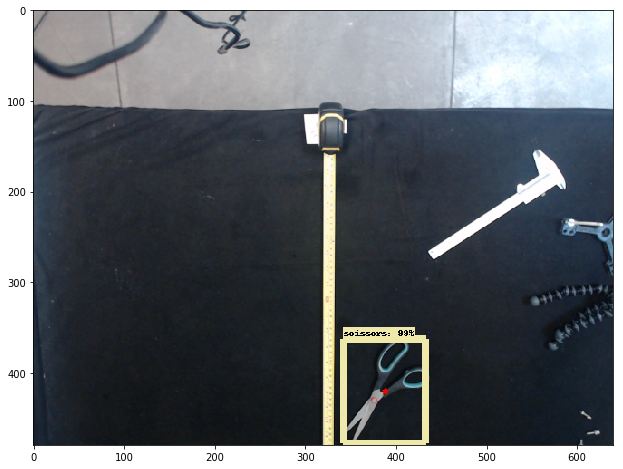

In [176]:
cam = cv2.VideoCapture(2)
#cam = cv2.VideoCapture(0)
ret, frame = cam.read()
cv2.destroyAllWindows()
del(cam)


if ret: 
    Im_np_rgb=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    output_dict=DORtoolbox.Execute(Im_np_rgb)


boxes,centres = DORtoolbox.get_boxes_with_label_and_threshold("scissors", 0.8, output_dict, Im_np_rgb, category_index)
for centre in centres:
    plt.plot(centre[0],centre[1], 'r*', lw=1000)
plt.show()

Estrategia para el lunes: hacer que el robot se acerque al puntito rojo 

In [177]:
output_dict['detection_scores'][output_dict['detection_classes']==87]

array([0.9985089], dtype=float32)

In [178]:
output_dict['detection_classes']

array([87,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=uint8)

# Camera calibration
Podemos hacer un modelo complicado para calibrar la cámara. Sin embargo, asumiendo que estamos trabajando en un plano fijo en Z, podemos crear un modelo empírico simple que podemos usar para nuestro robot. Está basado en cuatro vectores U, V, X, Y recolectados usando la cámara y mediciones.

In [179]:
from sklearn import linear_model
class CameraObj:
    def __init__(self):
        self.calibrationdata={
		"X" : np.array([[-130],[210],[100]]),
		"Y" : np.array([[-320], [-250], [-160]]),
		"U" : np.array([[408], [167], [263]]),
		"V" : np.array([[312], [368], [423]])
	}
        self.calibrate()
        
    def calibrate(self, calibrationdata=None):
        if not(calibrationdata is None):
            self.calibrationdata=calibrationdata
        self.regX = linear_model.LinearRegression()
        self.regX.fit(self.calibrationdata["U"],self.calibrationdata["X"])
        
        
        self.regY = linear_model.LinearRegression()
        self.regY.fit(self.calibrationdata["V"],self.calibrationdata["Y"])

        self.w0=self.regX.intercept_ 
        self.w1=self.regX.coef_
        self.s0=self.regY.intercept_
        self.s1=self.regY.coef_
        
    def PredictXY(self, centre_in_pixels):
        POS=np.zeros(2)
        
        
        POS[0]= self.regX.predict(np.array([[centre_in_pixels[0]]]))
        POS[1]= self.regY.predict(np.array([[centre_in_pixels[1]]]))

        return POS
    
    def rotaterobot(self, POS):
        if type(POS) is not np.ndarray:
            POS=np.array(POS)
        Rotation_Robot_wrt_Real=np.array([[np.cos(0.524), -np.sin(0.524)],[np.sin(0.524), np.cos(0.524)]]) #radians
        return np.matmul(Rotation_Robot_wrt_Real, POS)
 

[458.02201037] [[-1.4248998]] [-773.09003355] [[1.44086138]]


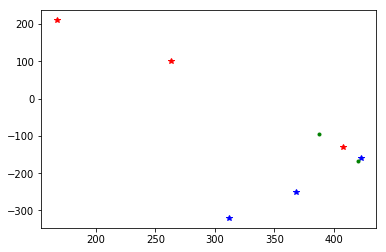

In [180]:
Camera=CameraObj()

plt.plot(Camera.calibrationdata["U"],Camera.calibrationdata["X"],"r*")
plt.plot(Camera.calibrationdata["V"],Camera.calibrationdata["Y"],"b*")

for center in centres:
    plt.plot(center[0],Camera.PredictXY(center)[0], 'g.')
    plt.plot(center[1],Camera.PredictXY(center)[1], 'g.')
print(Camera.w0, Camera.w1, Camera.s0, Camera.s1)

## Inference 

In [181]:
for center in centres:
    POS_frame=Camera.PredictXY(center)
    POS_robot=Camera.rotaterobot(POS_frame)
    print(POS_robot)

[   1.64907603 -192.18427225]
